Loading data...
Creating land cover mask...
NDVI variable: NDVI_VNP43C4_GHA
CHIRPS variable: CHIRPS_mm_per_week


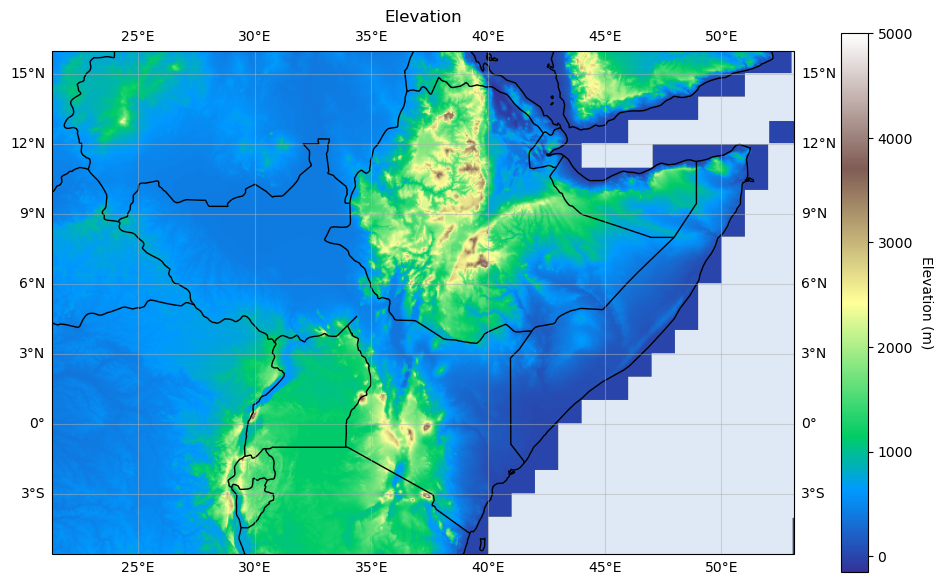

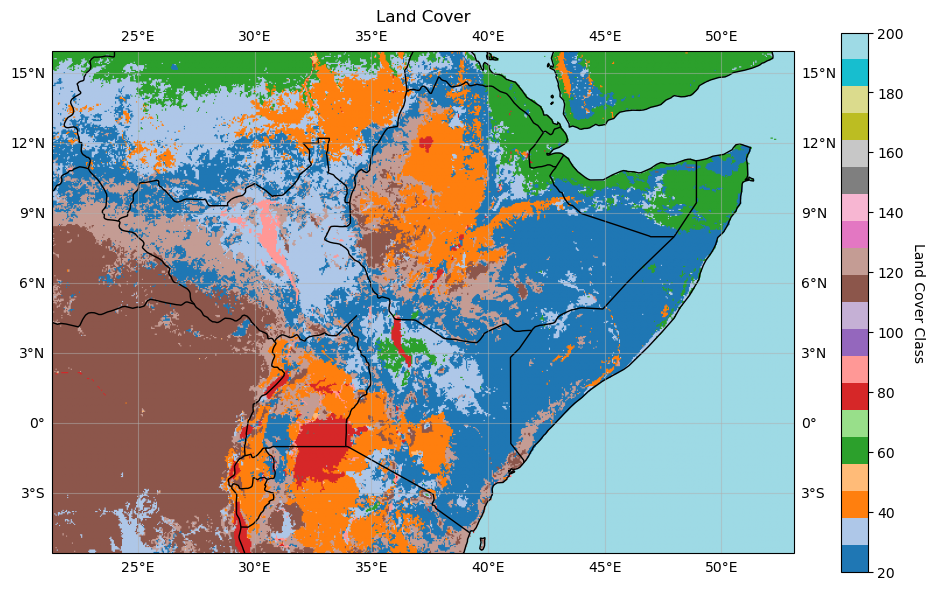

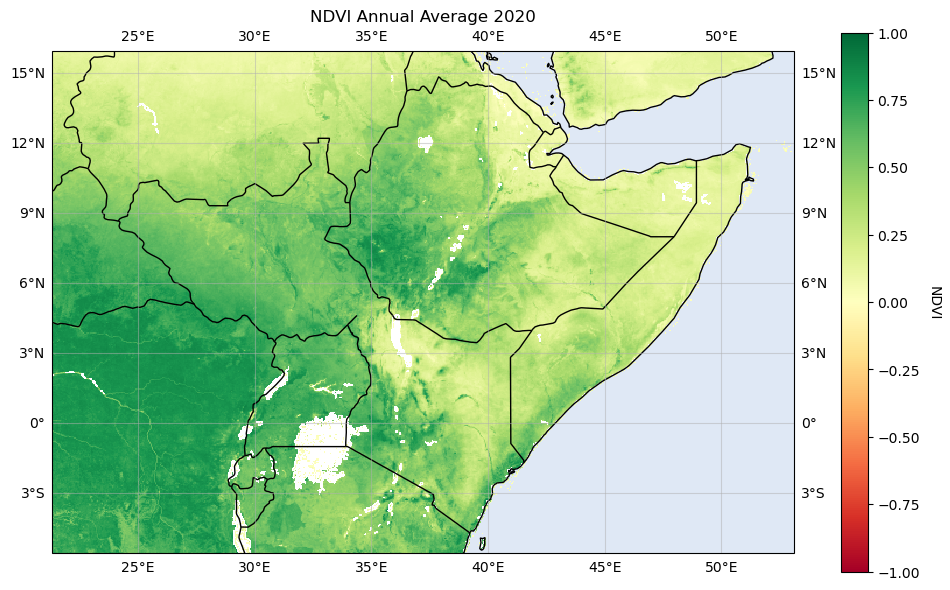

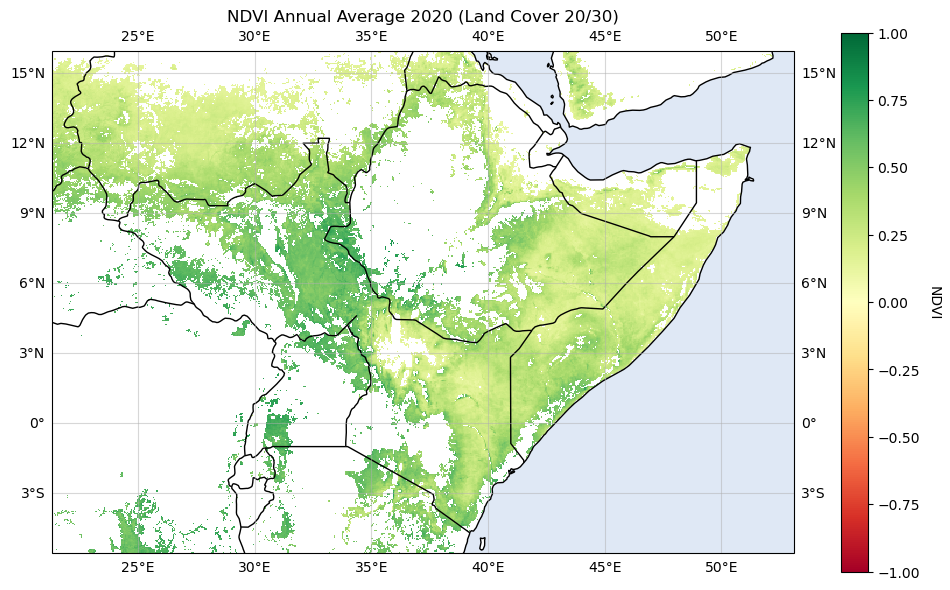

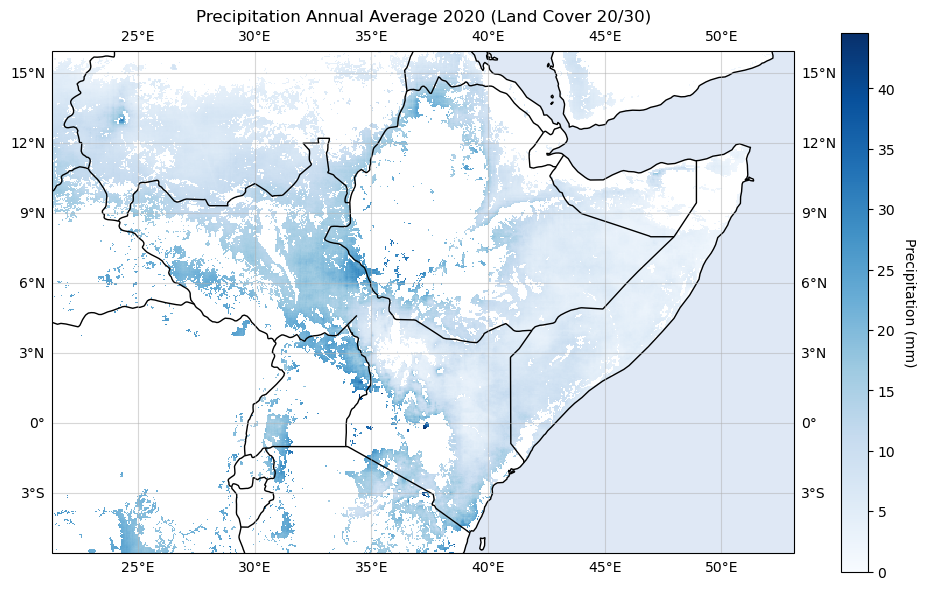

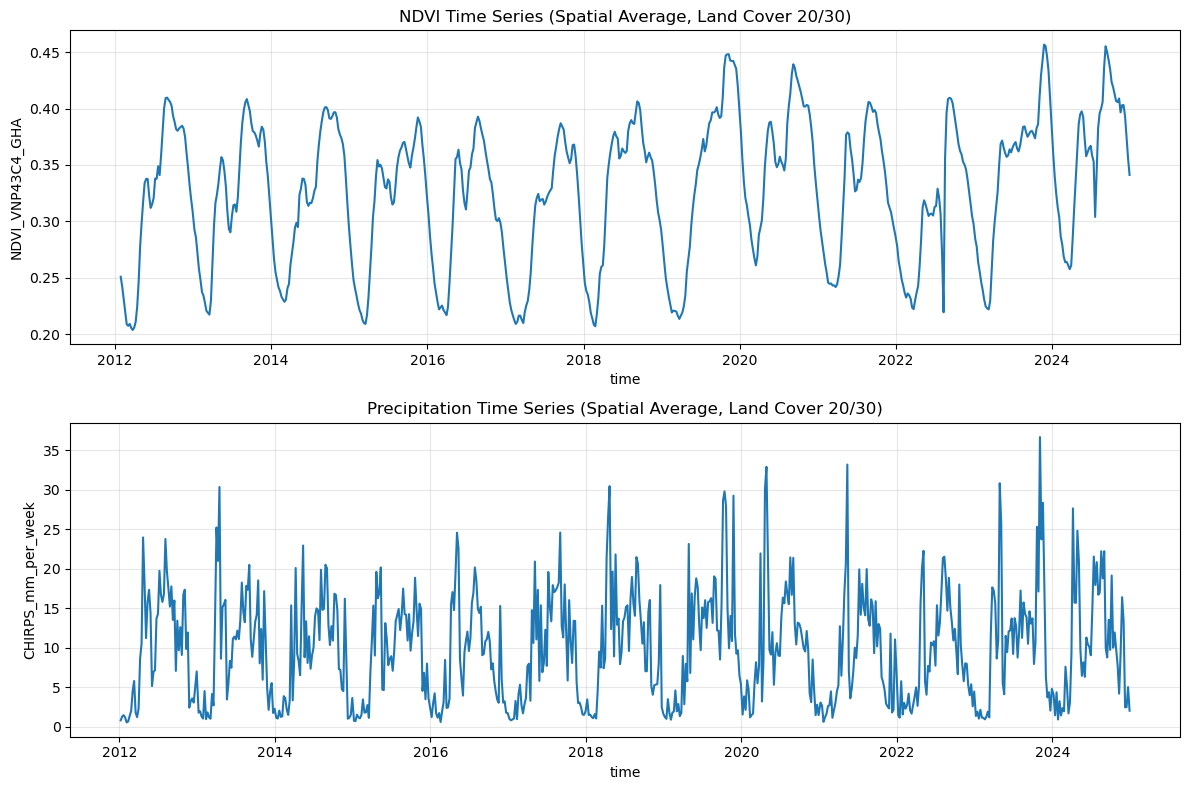

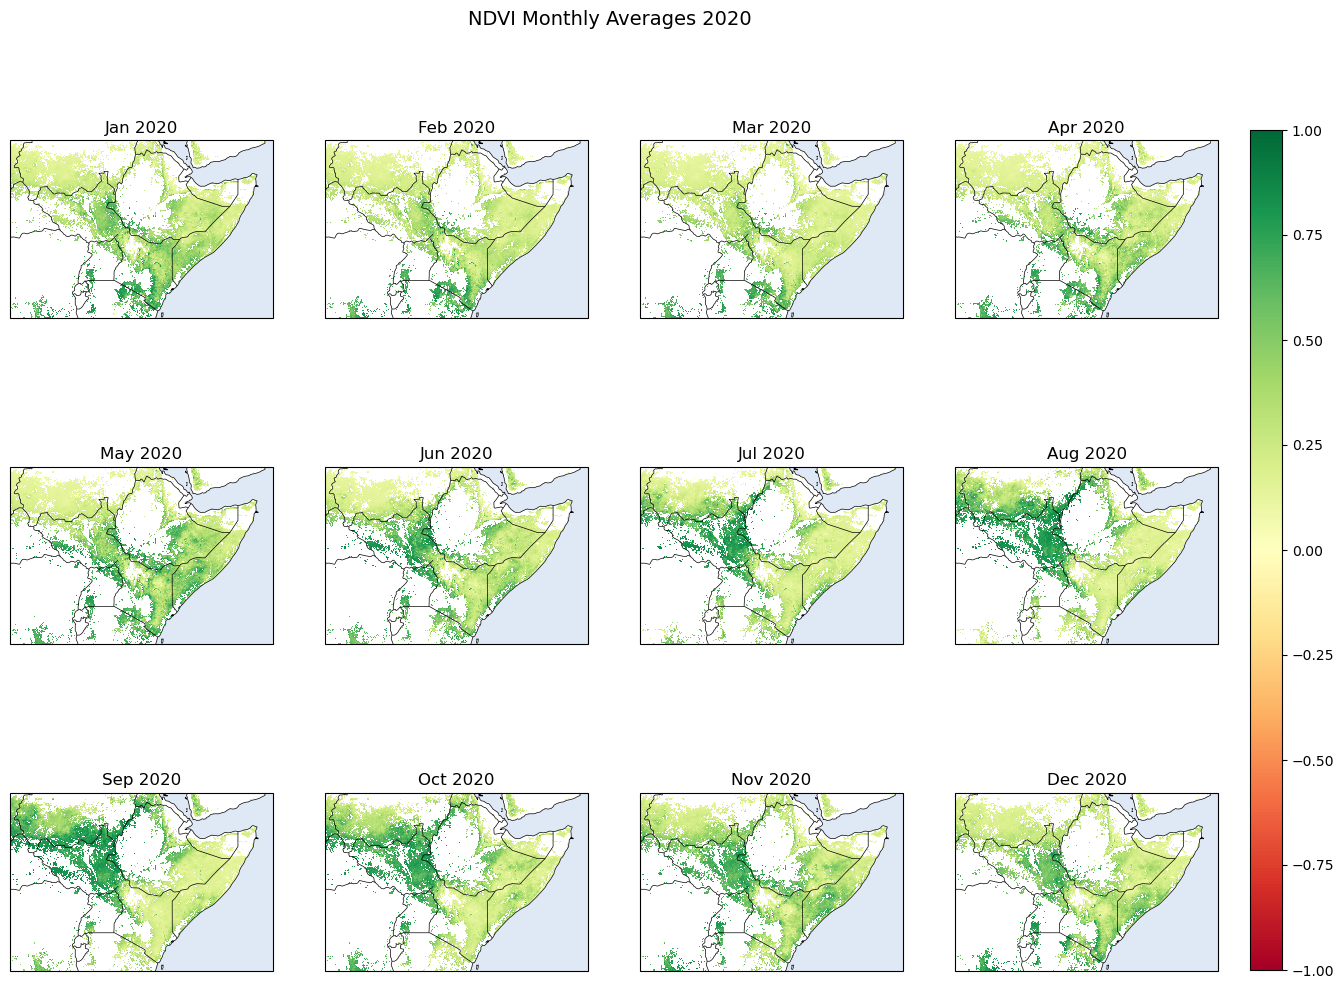

In [45]:
# Import required libraries
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Data paths
path_to_NDVI_data = "/ptmp/mp002/ellis/veg_forecast/NDVI_VNP43C4_v002_GHA.nc"
path_to_CHIRPS_data = "//ptmp/mp002/ellis/veg_forecast/CHIRPS_v002_weekly_sum_VNP43C4_GHA.nc"
path_elevation = "/ptmp/mp002/ellis/veg_forecast/srtm_5km_projection.tif"
path_landcover = "/ptmp/mp002/ellis/veg_forecast/COPERNICUS_Landcover_2019_GHA_reprojected.tif"

# Define bounding box coordinates
BBOX = {'min_lat': -5.5820, 'max_lat': 15.98, 'min_lon': 21.3070, 'max_lon': 53.14}

def load_and_subset_netcdf(file_path, bbox):
    """Load NetCDF data and apply spatial subset (assuming descending lat)"""
    ds = xr.open_dataset(file_path)
    # For descending latitudes, reverse the slice
    return ds.sel(lat=slice(bbox['max_lat'], bbox['min_lat']), 
                  lon=slice(bbox['min_lon'], bbox['max_lon']))

def load_and_subset_raster(raster_path, bbox):
    """Load raster and subset to bounding box"""
    with rasterio.open(raster_path) as src:
        window = rasterio.windows.from_bounds(
            bbox['min_lon'], bbox['min_lat'], bbox['max_lon'], bbox['max_lat'], src.transform)
        data = src.read(1, window=window)
        transform = rasterio.windows.transform(window, src.transform)
        
        height, width = data.shape
        lons_1d = [rasterio.transform.xy(transform, 0, col)[0] for col in range(width)]
        lats_1d = [rasterio.transform.xy(transform, row, 0)[1] for row in range(height)]
        lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)
        
        return data, lons_2d, lats_2d

def create_landcover_mask(landcover_data, valid_classes=[20, 30]):
    """Create mask for specific land cover classes"""
    return np.isin(landcover_data, valid_classes)

def regrid_mask(mask, mask_lons, mask_lats, target_ds):
    """Regrid land cover mask to match dataset resolution using nearest neighbor"""
    target_lons, target_lats = np.meshgrid(target_ds.lon.values, target_ds.lat.values)
    
    mask_points = np.column_stack([mask_lons.ravel(), mask_lats.ravel()])
    target_points = np.column_stack([target_lons.ravel(), target_lats.ravel()])
    
    tree = cKDTree(mask_points)
    _, indices = tree.query(target_points)
    
    return mask.ravel()[indices].reshape(target_lons.shape)

def plot_data(data, title="", bbox=BBOX, cmap='viridis', vmin=None, vmax=None, 
              apply_mask=None, colorbar_label=""):
    """Generic plotting function for both NetCDF and raster data"""
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Apply mask if provided
    if apply_mask is not None:
        if hasattr(data, 'where'):  # xarray
            data = data.where(apply_mask)
        else:  # numpy array
            data = np.where(apply_mask, data, np.nan)
    
    # Plot based on data type
    if hasattr(data, 'plot'):  # xarray
        im = data.plot(ax=ax, transform=ccrs.PlateCarree(), 
                       cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    else:  # numpy array (raster)
        im = ax.imshow(data, extent=[bbox['min_lon'], bbox['max_lon'], 
                                   bbox['min_lat'], bbox['max_lat']], 
                      transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN, alpha=0.3)
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_xlim([bbox['min_lon'], bbox['max_lon']])
    ax.set_ylim([bbox['min_lat'], bbox['max_lat']])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    if colorbar_label:
        cbar.set_label(colorbar_label, rotation=270, labelpad=15)
    
    plt.title(title)
    plt.tight_layout()
    return fig

def get_time_averaged_data(dataset, var_name, time_selection):
    """Get time-averaged data with flexible selection"""
    if isinstance(time_selection, str) and len(time_selection) == 4:
        return dataset[var_name].sel(time=time_selection).mean(dim='time')
    elif isinstance(time_selection, str) and len(time_selection) == 7:
        return dataset[var_name].sel(time=time_selection).mean(dim='time')
    else:
        return dataset[var_name].sel(time=time_selection, method='nearest')

def plot_monthly_comparison(dataset, var_name, year, mask=None, cmap='RdYlGn', 
                           vmin=-1, vmax=1, title_prefix=""):
    """Plot monthly comparison for a given year"""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for i, month in enumerate(months):
        month_data = dataset[var_name].sel(time=f'{year}-{i+1:02d}').mean(dim='time')
        if mask is not None:
            month_data = month_data.where(mask)
        
        im = month_data.plot(ax=axes[i], transform=ccrs.PlateCarree(), 
                            cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
        axes[i].set_title(f"{month} {year}")
        axes[i].add_feature(cfeature.COASTLINE, linewidth=0.5)
        axes[i].add_feature(cfeature.BORDERS, linewidth=0.5)
        axes[i].add_feature(cfeature.OCEAN, alpha=0.3)
        axes[i].set_xlim([BBOX['min_lon'], BBOX['max_lon']])
        axes[i].set_ylim([BBOX['min_lat'], BBOX['max_lat']])
    
    # Add colorbar
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.suptitle(f'{title_prefix} Monthly Averages {year}', fontsize=14, y=0.95)
    return fig

# Main analysis
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    ndvi_ds = load_and_subset_netcdf(path_to_NDVI_data, BBOX)
    chirps_ds = load_and_subset_netcdf(path_to_CHIRPS_data, BBOX)
    
    elevation_data, elevation_lons, elevation_lats = load_and_subset_raster(path_elevation, BBOX)
    landcover_data, landcover_lons, landcover_lats = load_and_subset_raster(path_landcover, BBOX)
    
    # Create and regrid land cover mask
    print("Creating land cover mask...")
    landcover_mask = create_landcover_mask(landcover_data)
    ndvi_landcover_mask = regrid_mask(landcover_mask, landcover_lons, landcover_lats, ndvi_ds)
    
    # Get variable names
    ndvi_var = list(ndvi_ds.data_vars)[0]
    chirps_var = list(chirps_ds.data_vars)[0]
    
    print(f"NDVI variable: {ndvi_var}")
    print(f"CHIRPS variable: {chirps_var}")
    
    # Plot raster data
    plot_data(elevation_data, "Elevation", cmap='terrain', colorbar_label='Elevation (m)')
    plt.show()
    
    plot_data(landcover_data, "Land Cover", cmap='tab20', colorbar_label='Land Cover Class')
    plt.show()
    
    # NDVI plots
    ndvi_2020 = get_time_averaged_data(ndvi_ds, ndvi_var, '2020')
    
    plot_data(ndvi_2020, "NDVI Annual Average 2020", 
              cmap='RdYlGn', vmin=-1, vmax=1, colorbar_label='NDVI')
    plt.show()
    
    plot_data(ndvi_2020, "NDVI Annual Average 2020 (Land Cover 20/30)", 
              cmap='RdYlGn', vmin=-1, vmax=1, apply_mask=ndvi_landcover_mask, 
              colorbar_label='NDVI')
    plt.show()
    
    # Precipitation plots
    chirps_2020 = get_time_averaged_data(chirps_ds, chirps_var, '2020')
    
    plot_data(chirps_2020, "Precipitation Annual Average 2020 (Land Cover 20/30)", 
              cmap='Blues', vmin=0, apply_mask=ndvi_landcover_mask, 
              colorbar_label='Precipitation (mm)')
    plt.show()
    
    # Time series
    ndvi_ts = ndvi_ds[ndvi_var].where(ndvi_landcover_mask).mean(dim=['lat', 'lon'])
    chirps_ts = chirps_ds[chirps_var].where(ndvi_landcover_mask).mean(dim=['lat', 'lon'])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ndvi_ts.plot(ax=ax1)
    ax1.set_title('NDVI Time Series (Spatial Average, Land Cover 20/30)')
    ax1.grid(True, alpha=0.3)
    
    chirps_ts.plot(ax=ax2)
    ax2.set_title('Precipitation Time Series (Spatial Average, Land Cover 20/30)')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Monthly comparison
    plot_monthly_comparison(ndvi_ds, ndvi_var, 2020, mask=ndvi_landcover_mask, 
                           title_prefix="NDVI")
    plt.show()